In [9]:
import sys
import os

%load_ext autoreload
%autoreload 2

# Usar el directorio de trabajo actual en lugar de __file__
path = os.getcwd()
sys.path.insert(0, os.path.join(path, '..', 'src'))

import data_preprocesing as dp
import pandas as pd
import numpy as np
import mlflow

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from mlflow.models.signature import infer_signature
import mlflow
import mlflow.sklearn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
df = pd.read_csv(r'..\data\raw\base_train.csv',sep='|', encoding='utf-8')
df_test = pd.read_csv(r'..\data\raw\base_prueba.csv',sep='|', encoding='utf-8')
preprocesor = dp.ModelPreprocessor()
X,y = preprocesor.transform(df)
print("X shape:", X.shape)
print("y shape:", y.shape)
print("shape of df_test:", df_test.shape)

X shape: (7516, 29)
y shape: (7516,)
shape of df_test: (5889, 27)


In [17]:
from mlflow.tracking import MlflowClient

client = MlflowClient()
experiment = client.get_experiment_by_name("default_train_selected_features_optimo")

if experiment is not None:
    client.restore_experiment(experiment.experiment_id)


<Axes: title={'center': 'Distribución de la variable objetivo'}, xlabel='default'>

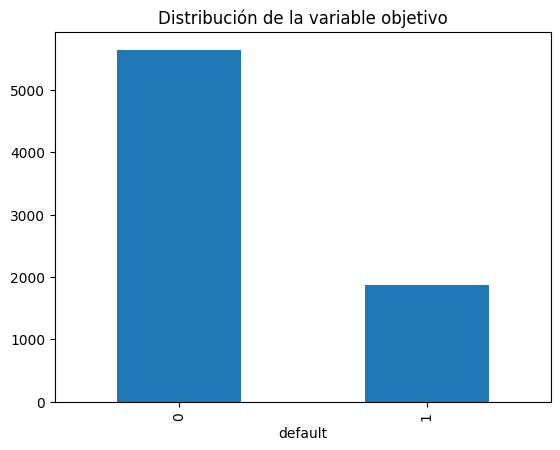

In [18]:
y.value_counts().plot(kind='bar', title='Distribución de la variable objetivo')


In [19]:
from sklearn.model_selection import train_test_split

preprocesor = dp.ModelPreprocessor()
X, y = preprocesor.transform(df)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train/Test split:", X_train.shape, X_test.shape)


Train/Test split: (6012, 29) (1504, 29)


# seleccion de modelos

In [20]:
def train_with_gridsearch(X_train, X_test, y_train, y_test, model, param_grid, model_name):
    with mlflow.start_run(run_name=model_name):
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring='f1',
            cv=3,
            n_jobs=-1,
            verbose=1
        )

        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_

        # Evaluación interna
        y_pred = best_model.predict(X_test)
        y_proba = best_model.predict_proba(X_test)[:, 1]

        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)

        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metrics({
            "f1_score": f1,
            "precision": precision,
            "recall": recall,
            "roc_auc": auc
        })

        signature = infer_signature(X_test, y_pred)
        mlflow.sklearn.log_model(best_model, model_name, signature=signature, input_example=X_test.iloc[:1])

        print(f"\n✅ {model_name} -> F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {auc:.4f}")
        print("📊 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

        return best_model  # 👈 aquí está la clave


In [21]:
scale_pos = (y_train == 0).sum() / (y_train == 1).sum()

param_grid_lr = {
    'C': [0.01, 0.1, 0.5, 1],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
    'class_weight': ['balanced']
}

param_grid_rf = {
    'n_estimators': [200, 300, 500],
    'max_depth': [10, 20, 40],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced']
}

param_grid_xgb = {
    'n_estimators': [200, 400],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'scale_pos_weight': [scale_pos, scale_pos * 1.5]
}

param_grid_lgb = {
    'n_estimators': [200, 400],
    'max_depth': [10, 20, -1],
    'learning_rate': [0.01, 0.05],
    'num_leaves': [31, 50],
    'min_data_in_leaf': [20, 40],
    'class_weight': ['balanced']
}

In [22]:
# ============================
# 5. Entrenamiento
# ============================

train_with_gridsearch(
    X_train, X_test, y_train, y_test,
    model=LogisticRegression(max_iter=500, random_state=42),
    param_grid=param_grid_lr,
    model_name="LogisticRegression_HPO"
)

train_with_gridsearch(
    X_train, X_test, y_train, y_test,
    model=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    model_name="RandomForest_HPO"
)

train_with_gridsearch(
    X_train, X_test, y_train, y_test,
    model=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    param_grid=param_grid_xgb,
    model_name="XGBoost_HPO"
)

train_with_gridsearch(
    X_train, X_test, y_train, y_test,
    model=LGBMClassifier(random_state=42),
    param_grid=param_grid_lgb,
    model_name="LightGBM_HPO"
)

Fitting 3 folds for each of 8 candidates, totalling 24 fits

✅ LogisticRegression_HPO -> F1: 0.5384, Precision: 0.4242, Recall: 0.7367, AUC: 0.7679
📊 Confusion Matrix:
 [[752 376]
 [ 99 277]]
🏃 View run LogisticRegression_HPO at: http://127.0.0.1:5000/#/experiments/10/runs/3e40b9ec9f544436aa51d590dd19dd1e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/10
Fitting 3 folds for each of 72 candidates, totalling 216 fits

✅ RandomForest_HPO -> F1: 0.5373, Precision: 0.4727, Recall: 0.6223, AUC: 0.7833
📊 Confusion Matrix:
 [[867 261]
 [142 234]]
🏃 View run RandomForest_HPO at: http://127.0.0.1:5000/#/experiments/10/runs/d93a4099eff249b093253a86695daba1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/10
Fitting 3 folds for each of 36 candidates, totalling 108 fits

✅ XGBoost_HPO -> F1: 0.5533, Precision: 0.4374, Recall: 0.7527, AUC: 0.7812
📊 Confusion Matrix:
 [[764 364]
 [ 93 283]]
🏃 View run XGBoost_HPO at: http://127.0.0.1:5000/#/experiments/10/runs/a928e96ce0854fbd8c8d

  File "c:\Users\sojua\OneDrive\Desktop\prueba_ifrs9\env\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\sojua\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\sojua\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\sojua\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 1503, number of negative: 4509
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2091
[LightGBM] [Info] Number of data points in the train set: 6012, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] 

LGBMClassifier(class_weight='balanced', learning_rate=0.01, max_depth=20,
               min_data_in_leaf=20, n_estimators=400, random_state=42)

In [ ]:

param_grid = {
    'n_estimators': [200, 400, 600],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [3, 6, 10,20],
    'learning_rate': [0.01, 0.05, 0.1,0.001],
    'scale_pos_weight': [scale_pos, scale_pos * 1.5]
}

best_model = train_with_gridsearch(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    model=LGBMClassifier(random_state=42),
    param_grid=param_grid,
    model_name="XGBoost_Optimized"
)

Fitting 3 folds for each of 192 candidates, totalling 576 fits


### pruebas OOS

In [28]:
df_val = pd.read_csv(r'..\data\raw\base_validacion.csv', sep='|', encoding='utf-8')
X_val, y_val = preprocesor.transform(df_val)

y_pred_val = best_model.predict(X_val)
y_proba_val = best_model.predict_proba(X_val)[:, 1]
f1_val = f1_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_proba_val)
print(f"\n✅ LightGBM Optimo -> F1: {f1_val:.4f}, Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, AUC: {auc_val:.4f}")
print("📊 Confusion Matrix:\n", confusion_matrix(y_val, y_pred_val))


✅ LightGBM Optimo -> F1: 0.4098, Precision: 0.3472, Recall: 0.5000, AUC: 0.6607
📊 Confusion Matrix:
 [[309 141]
 [ 75  75]]
